In [1]:
!pip install keras==2.6

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

# For preprocessing
import re 
import nltk
import string
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import SnowballStemmer
import pickle
from collections import Counter  #to count elements in list

# For Building the model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import ticker
%matplotlib inline
import seaborn as sns

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Reading the dataset

In [3]:
df = pd.read_csv('cleaned_df.csv')

# Final Cleaning

In [4]:
df['text'] = df['text'].str.replace('\d+', '')
df["text"] = df["text"].str.replace("?"," ")
df["text"] = df["text"].str.replace("!"," ")
df["text"] = df["text"].str.replace("_"," ")
df["text"] = df["text"].str.replace(","," ")
df["text"] = df["text"].str.replace("&"," ")
df["text"] = df["text"].str.replace("\n"," ")
df["text"] = df["text"].str.replace("/"," ")
df["text"] = df["text"].str.replace("-"," ")
df["text"] = df["text"].str.replace("$"," ")
df["text"] = df["text"].str.replace("\r"," ")
df["text"] = df["text"].str.replace("."," ")
df["text"] = df["text"].str.replace("~"," ")
df["text"] = df["text"].str.replace("["," ")
df["text"] = df["text"].str.replace("]"," ")

In [5]:
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [6]:
def text_to_words(text):
# tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

In [7]:
X = list(map(text_to_words, df['text']))
len(X)

21862

In [8]:
# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['score'])

In [9]:
# Train and test split
y = pd.get_dummies(df['score'])
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, 
                                                  random_state=1)

# Bag of words (BOW) feature extraction

In [10]:
vocabulary_size = len(X)

count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

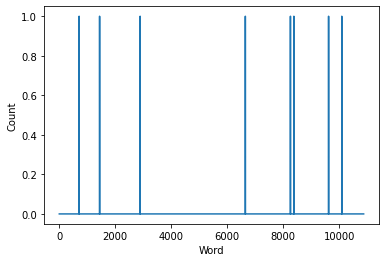

In [11]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

In [12]:
import tensorflow as tf
print(tf.__version__)

2.6.4


In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 21862
max_len=32

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['text'][1000])
X, tokenizer = tokenize_pad_sequences(df['text'])
print('After Tokenization & Padding \n', X[1000])

Before Tokenization & Padding 
 top brokers recommend subscribe syngene international ipo
After Tokenization & Padding 
 [  72  812 1310 2239 5059  253  110    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [14]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [15]:
## Traintest split

y = pd.get_dummies(df['score'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (13991, 32) (13991, 3)
Validation Set -> (3498, 32) (3498, 3)
Test Set -> (4373, 32) (4373, 3)


In [16]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Bidirectional LSTM

2022-09-29 12:25:45.217804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 12:25:45.315114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 12:25:45.315885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 12:25:45.317416: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

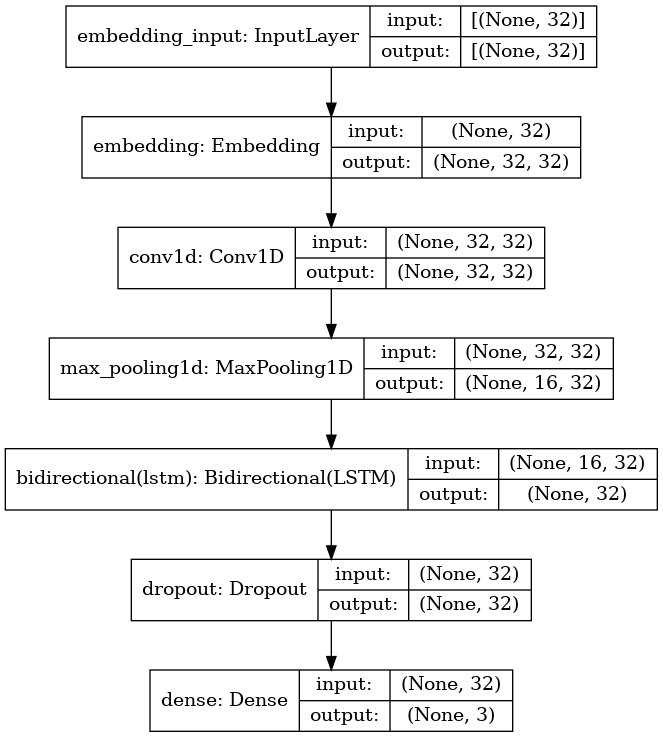

In [17]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD , RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = len(X)
embedding_size = 32
epochs=500
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.1

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))


tf.keras.utils.plot_model(model, show_shapes=True)


#################################################################
# #model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# #model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(64)))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(32)))
# model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(3, activation='softmax'))

In [18]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 32)            699584    
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                6272      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 709,059
Trainable params: 709,059
Non-trainable params: 0
__________________________________________________

# Compile model

In [19]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

In [20]:
import warnings
warnings.filterwarnings("ignore")

# Training the model

In [21]:
batch_size = 16
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

2022-09-29 12:25:49.593229: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-09-29 12:25:53.294890: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


875/875 [==============================] - 18s 10ms/step - loss: 1.0590 - accuracy: 0.4543 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0577 - val_accuracy: 0.4434 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/500
875/875 [==============================] - 7s 9ms/step - loss: 1.0560 - accuracy: 0.4546 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0568 - val_accuracy: 0.4434 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/500
875/875 [==============================] - 7s 8ms/step - loss: 1.0550 - accuracy: 0.4546 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0567 - val_accuracy: 0.4434 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/500
875/875 [==============================] - 7s 8ms/step - loss: 1.0541 - accuracy: 0.4546 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0561 - val_accuracy: 0.4434 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/500
875/875 [=========================

# Evaluate model on the test set

In [22]:

loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.7960
Precision : 0.7966
Recall    : 0.7960
F1 Score  : 0.7963


# Save the model architecture & the weights

In [23]:
model.save('model.h5')
print('Model saved')

Model saved


# Loaing the model

In [2]:
from keras.models import load_model

# Load model
model = load_model('model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = [-1, 0, 1]
    max_len=64
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [4]:
#predict_class(['government stop crypto trading, future of crypto is in trouble'])